In [1]:
import pandas as pd
import geopandas as gpd
import json
from shapely.geometry import Point, LineString

In [33]:
# data_frames = []

# for i in range(1, 16):
#     file_name = f"../res/result{i}.csv"
#     df = pd.read_csv(file_name)
#     data_frames.append(df)

# # 使用 concat 函数将所有 DataFrame 合并为一个
# result = pd.concat(data_frames)

# result.to_csv("../res/sample_taxi_region.csv")
df_order = pd.read_csv("../res/sample_taxi_region.csv")

In [34]:
# 按照出租车编号对数据进行分组
df_grouped = df_order.groupby('taxi_id')

In [35]:
# from datetime import datetime
# # 定义一个将时间字符串转换为datetime类型的函数
# def convert_time(time_string):
#     return datetime.strptime(time_string, '%H:%M:%S')

# # 使用apply行向量函数将整个时间列转换为datetime类型
# df_grouped['time'] = df_grouped['time'].apply(lambda x: convert_time(x))
# print(df_grouped.head(1000))
print(type(df_grouped))
df_grouped_slice = df_grouped.head(1000)
print(type(df_grouped_slice))

<class 'pandas.core.groupby.generic.DataFrameGroupBy'>
<class 'pandas.core.frame.DataFrame'>


In [32]:
# 分别处理每个出租车的订单
orders = []
df_sorted = df_grouped.apply(lambda x: x.sort_values('time'))
# df_sorted.to_csv('../res/sorted.csv')
order_started = False
order_start_lat = None
order_start_lon = None
order_end_lat = None
order_end_lon = None
order_start_district = None
order_start_block = None
order_end_district = None
order_end_block = None
for _, row in df_sorted.iterrows():
    if row['is_passenger'] == 1 and not order_started:
        # 如果订单开始，记录起始点位置和时间
        order_start_lat = row['lat']
        order_start_lon = row['lon']
        order_start_time = row['time']
        order_start_district = row['region']
        order_start_block = row['block_id']
        order_started = True
    elif row['is_passenger'] == 0 and order_started:
        # 如果订单结束，记录终点位置，添加订单记录
        order_end_lat = row['lat']
        order_end_lon = row['lon']
        order_end_time = row['time']
        order_end_district = row['region']
        order_end_block = row['block_id']
        orders.append((row['taxi_id'], order_start_lat, order_start_lon, order_end_lat, order_end_lon, order_start_time, order_end_time, order_start_district, order_start_block, order_end_district, order_end_block))
        order_started = False

NameError: name 'df_grouped' is not defined

In [20]:
# 将订单记录整合到DataFrame中
orders_df = pd.DataFrame(orders, columns=['taxi_id', 'start_lat', 'start_lon', 'end_lat', 'end_lon', 'start_time', 'end_time', 'start_district', 'start_block', 'end_district', 'end_block'])
orders_df.to_csv('../res/orders.csv', index=False)

In [2]:
# 各区街道出发、到达数量统计
df_orders = pd.read_csv('../res/orders.csv')

# 根据district_block进行分组，统计每个区块的订单数量
from_district_block = df_orders.groupby('start_block')['taxi_id'].count().sort_values(ascending=False)
to_district_block = df_orders.groupby('end_block')['taxi_id'].count().sort_values(ascending=False)

# print(from_district_block)
from_district_block.to_csv('../res/from.csv')
# print(to_district_block)

import geopandas as gpd
gdf = gpd.read_file('../res/sz_block_mars.json')

grouped_from = df_orders.groupby(['start_block'])['taxi_id'].count()
df_from = pd.DataFrame(grouped_from).reset_index().rename(columns={"start_block": "BLOCK_ID", "taxi_id": "from_count"})

grouped_to = df_orders.groupby(["end_block"])["taxi_id"].count()
df_to = pd.DataFrame(grouped_to).reset_index().rename(columns={"end_block": "BLOCK_ID", "taxi_id": "to_count"})

# print(df_from.columns)
# print(df_to.columns)

df_counts = pd.merge(df_from, df_to, on=["BLOCK_ID"], how="outer")

df_counts["total_count"] = df_counts[["from_count", "to_count"]].sum(axis=1)

df_counts.sort_values('BLOCK_ID').to_csv('../res/count.csv')
# print(df_counts[(df_counts['BLOCK_ID']==-1) & (df_counts['DISTRICT']!='福田区')].shape[0])
df_counts = df_counts[df_counts['BLOCK_ID']!=-1]

# 将计数表格与GeoDataFrame合并，以保留区块的地理信息和其他属性信息
gdf_counts = pd.merge(gdf, df_counts, on=["BLOCK_ID"], how="outer")

# print(len(gdf))
# print(gdf_counts.head(5))

import numpy as np
# 将计数信息写入属性表中
gdf_counts["properties"] = gdf_counts.apply(
    lambda row: {
        "ID": row["ID"],
        "AREA": row["AREA"],
        "ID1": row["ID1"],
        "AREA1": row["AREA1"],
        "NAME": row["NAME"],
        "DISTRICT": row["DISTRICT"],
        "DISTRICT_I": row["DISTRICT_I"],
        "BLOCK_ID": row["BLOCK_ID"],
        "from_count": row["from_count"] if not np.isnan(row['from_count']) else 0,
        "to_count": row["to_count"] if not np.isnan(row['to_count']) else 0,
        "total_count": row["total_count"] if not np.isnan(row['total_count']) else 0
    },
    axis=1
)

# 提取所有区块的GeoDataFrame并保存到新的GeoJSON文件中
gdf_counts[["geometry", "properties"]].to_file("../res/sz_block_mars_with_count.json", driver="GeoJSON")

In [9]:
# 从各区到各区的概率
cross_tab = pd.crosstab(df_orders['start_district'], df_orders['end_district'], normalize='index')
cross_tab_df = pd.DataFrame(cross_tab, columns=df_orders['end_district'].unique(), index=df_orders['start_district'].unique())
cross_tab_df = (cross_tab_df * 100).round(2)
cross_tab_df.index.name = 'Starting District'
cross_tab_df.columns.name = 'Ending District'
cross_tab_df.to_csv('../res/cross_tab.csv')

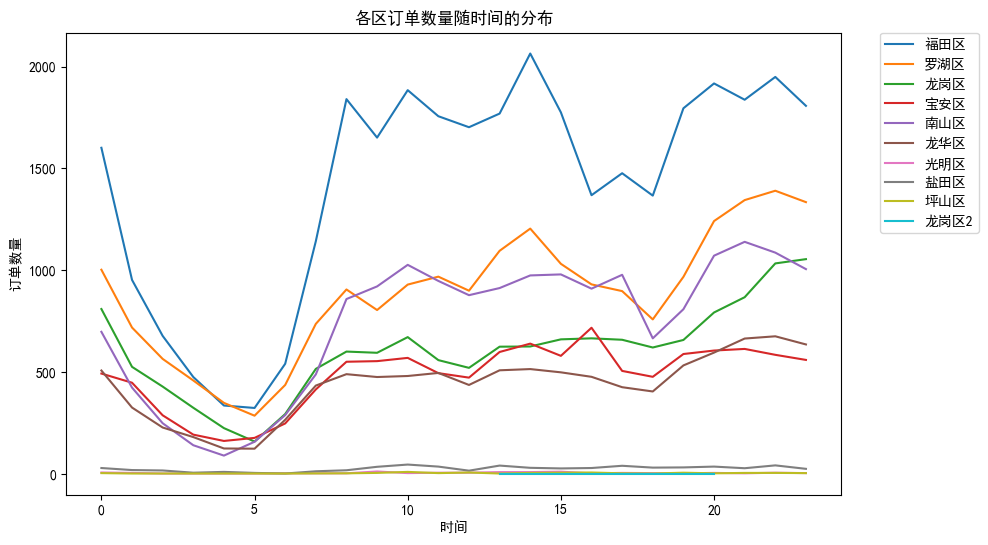

<Figure size 640x480 with 0 Axes>

In [13]:
#各区出发、到达的时间分布 折线图
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.family'] = ['SimHei']

df_orders = pd.read_csv('../res/orders.csv')

# 将出发时间列转化为时间类型
df_orders['start_time'] = pd.to_datetime(df_orders['start_time'])

# 按照行政区和出发时间进行分组，并计算每个小时的订单数量
grouped = df_orders.groupby([df_orders['start_district'], df_orders['start_time'].dt.hour])['taxi_id'].count()

# 将分组结果转为DataFrame，并将索引转为列
df_line = pd.DataFrame(grouped).reset_index()

# 获取所有区域列表
districts = df_orders['start_district'].dropna().unique()

# 绘制所有区域的订单数量随时间的折线图
fig, ax = plt.subplots(figsize=(10, 6))

for district in districts:
    # 筛选出当前区域的数据
    data = df_line[df_line['start_district'] == district]
    # 绘制折线图
    ax.plot(data['start_time'], data['taxi_id'], label=district)

# 设置坐标轴标签和标题
ax.set_xlabel('时间')
ax.set_ylabel('订单数量')
ax.set_title('各区订单数量随时间的分布')

# 添加图例
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0)

plt.show()
plt.savefig("../res/distribution.png", format='png')